In [1]:
import glob
import sys
import warnings
warnings.filterwarnings('ignore')

import xarray as xr
import cmocean

sys.path.append('/g/data/xv83/quantile-mapping/qq-workflows')
import validation
sys.path.append('/g/data/xv83/quantile-mapping/qqscale')
import utils

Matplotlib is building the font cache; this may take a moment.


In [2]:
def get_obs_files(obs, var):
    """Get obs data"""

    if obs == 'BARRA-R2':
        if var in ['hursmin', 'hursmax']:
            target_files = sorted(glob.glob(f'/g/data/ia39/australian-climate-service/test-data/observations/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/day/{var}/v20240516/*.nc'))
        else:
            target_files = sorted(glob.glob(f"/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/day/{var}/latest/*.nc"))

    return target_files[72:432]
    
    
def get_model_files(model, var):
    """Get model data"""
    
    if model == "ACCESS-CM2":
        hist_files = sorted(glob.glob(f"/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r4i1p1f1/day/{var}/gn/latest/*.nc"))

    return hist_files

In [3]:
hist_units = {
    'rsds': "W m-2",
    'tasmin': 'K',
    'tasmax': 'K',
    'hursmin': '%',
    'hursmax': '%',
    'sfcWind': 'm s-1',
    'sfcWindmax': 'm s-1',
}

target_units = {
    'rsds': "W m-2",
    'tasmin': 'K',
    'tasmax': 'K',
    'hursmin': '%',
    'hursmax': '%',
    'sfcWind': 'm s-1',
    'sfcWindmax': 'm s-1',
}

output_units = {
    'rsds': "W m-2",
    'tasmin': 'C',
    'tasmax': 'C',
    'hursmin': '%',
    'hursmax': '%',
    'sfcWind': 'm s-1',
    'sfcWindmax': 'm s-1',
}

clim_cbar = {
    'rsds': cmocean.cm.solar,
    'tasmin': cmocean.cm.thermal,
    'tasmax': cmocean.cm.thermal,
    'hursmin': cmocean.cm.thermal,
    'hursmax': cmocean.cm.thermal,
    'sfcWind': cmocean.cm.speed,
    'sfcWindmax': cmocean.cm.speed,
}

clim_levels = {
    'rsds': [115, 130, 145, 160, 175, 200, 225, 250, 275],
    'tasmin': [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26],
    'tasmax': [5, 8, 11, 14, 17, 20, 23, 26, 29, 31, 34, 37],
    'hursmin': [10, 15 ,20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80],
    'hursmax': [35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100],
    'sfcWind': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'sfcWindmax': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
}

diff_cbar = {
    'rsds': 'RdBu_r',
    'tasmin': 'RdBu_r',
    'tasmax': 'RdBu_r',
    'hursmin': 'RdBu_r',
    'hursmax': 'RdBu_r',
    'sfcWind': 'RdBu_r',
    'sfcWindmax': 'RdBu_r',
}

ratio_levels = [-30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30]

diff_levels = {
    'rsds': [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5],
    'tasmin': [-2.5, -2.0, -1.5, -1.0, -0.5, 0, 0.5, 1.0, 1.5, 2.0, 2.5],
    'tasmax': [-2.5, -2.0, -1.5, -1.0, -0.5, 0, 0.5, 1.0, 1.5, 2.0, 2.5],
    'hursmin': [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5],
    'hursmax': [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5],
    'sfcWind': [-1.0, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0],
    'sfcWindmax': [-1.0, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0],
}

In [4]:
def get_data(var, model, obs):
    """Plot the comparison"""

    hist_files = get_model_files(model, var)
    ds_hist = utils.read_data(
        hist_files,
        var,
        time_bounds=["1985", "2014"],
        input_units=hist_units[var],
        output_units=output_units[var],
    )
    hist_clim = ds_hist[var].mean('time', keep_attrs=True).compute()

    target_files = get_obs_files(obs, var)
    ds_target = utils.read_data(
        target_files,
        var,
        time_bounds=["1985", "2014"],
        input_units=target_units[var],
        output_units=output_units[var],
    )
    try:
        ds_target = ds_target.drop_vars('crs')
    except ValueError:
        pass
    target_clim = ds_target[var].mean('time', keep_attrs=True).compute()
    
    comparison_ratio = validation.spatial_comparison_data(
        target_clim,
        hist_clim,
        'multiplicative'
    )
    comparison_diff = validation.spatial_comparison_data(
        target_clim,
        hist_clim,
        'additive'
    )
    
    return hist_clim, target_clim, comparison_diff, comparison_ratio

### rsds

In [5]:
hist_clim, target_clim, comparison_diff, comparison_ratio = get_data("rsds", "ACCESS-CM2", "BARRA-R2")

In [ ]:
validation.spatial_comparison_plot(
    target_clim,
    hist_clim,
    comparison_diff,
    'BARRA-R2',
    'ACCESS-CM2',
    clim_cbar["rsds"],
    diff_cbar["rsds"],
    clim_levels["rsds"],
    diff_levels["rsds"],
    'additive',
    land_only=True,
    clim_extend='neither',
    print_mav=True,
)

mean absolute value: 2.62 


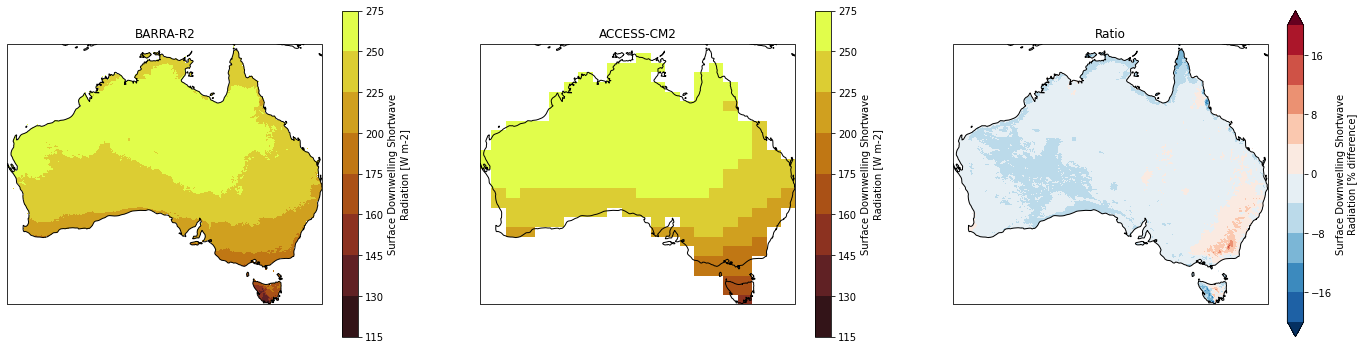

In [6]:
validation.spatial_comparison_plot(
    target_clim,
    hist_clim,
    comparison_ratio,
    'BARRA-R2',
    'ACCESS-CM2',
    clim_cbar["rsds"],
    diff_cbar["rsds"],
    clim_levels["rsds"],
    ratio_levels,
    'multiplicative',
    land_only=True,
    clim_extend='neither',
    print_mav=True,
)

### tasmin

In [7]:
hist_clim, target_clim, comparison_diff, comparison_ratio = get_data("tasmin", "ACCESS-CM2", "BARRA-R2")

In [ ]:
validation.spatial_comparison_plot(
    target_clim,
    hist_clim,
    comparison_diff,
    'BARRA-R2',
    'ACCESS-CM2',
    clim_cbar["tasmin"],
    diff_cbar["tasmin"],
    clim_levels["tasmin"],
    diff_levels["tasmin"],
    'additive',
    land_only=True,
    clim_extend='neither',
    print_mav=True,
)

mean absolute value: 13.09 


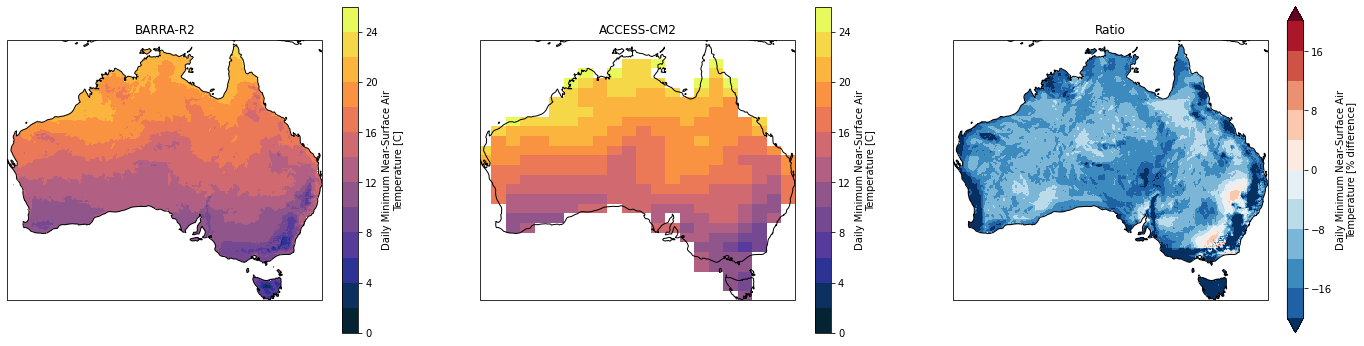

In [8]:
validation.spatial_comparison_plot(
    target_clim,
    hist_clim,
    comparison_ratio,
    'BARRA-R2',
    'ACCESS-CM2',
    clim_cbar["tasmin"],
    diff_cbar["tasmin"],
    clim_levels["tasmin"],
    ratio_levels,
    'multiplicative',
    land_only=True,
    clim_extend='neither',
    print_mav=True,
)

### tasmax

In [9]:
hist_clim, target_clim, comparison_diff, comparison_ratio = get_data("tasmax", "ACCESS-CM2", "BARRA-R2")

In [ ]:
validation.spatial_comparison_plot(
    target_clim,
    hist_clim,
    comparison_diff,
    'BARRA-R2',
    'ACCESS-CM2',
    clim_cbar["tasmax"],
    diff_cbar["tasmax"],
    clim_levels["tasmax"],
    diff_levels["tasmax"],
    'additive',
    land_only=True,
    clim_extend='neither',
    print_mav=True,
)

mean absolute value: 3.81 


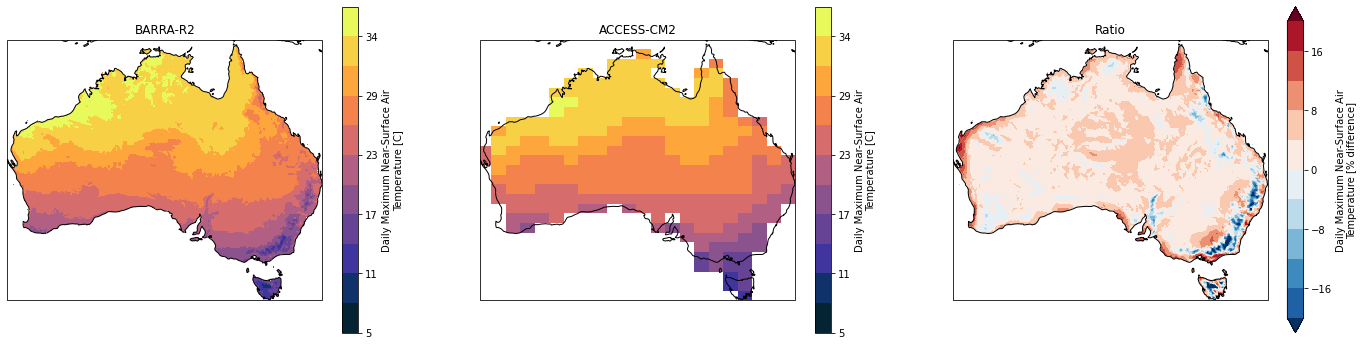

In [10]:
validation.spatial_comparison_plot(
    target_clim,
    hist_clim,
    comparison_ratio,
    'BARRA-R2',
    'ACCESS-CM2',
    clim_cbar["tasmax"],
    diff_cbar["tasmax"],
    clim_levels["tasmax"],
    ratio_levels,
    'multiplicative',
    land_only=True,
    clim_extend='neither',
    print_mav=True,
)

### sfcWind

In [11]:
hist_clim, target_clim, comparison_diff, comparison_ratio = get_data("sfcWind", "ACCESS-CM2", "BARRA-R2")

In [ ]:
validation.spatial_comparison_plot(
    target_clim,
    hist_clim,
    comparison_diff,
    'BARRA-R2',
    'ACCESS-CM2',
    clim_cbar["sfcWind"],
    diff_cbar["sfcWind"],
    clim_levels["sfcWind"],
    diff_levels["sfcWind"],
    'additive',
    land_only=True,
    clim_extend='neither',
    print_mav=True,
)

mean absolute value: 15.58 


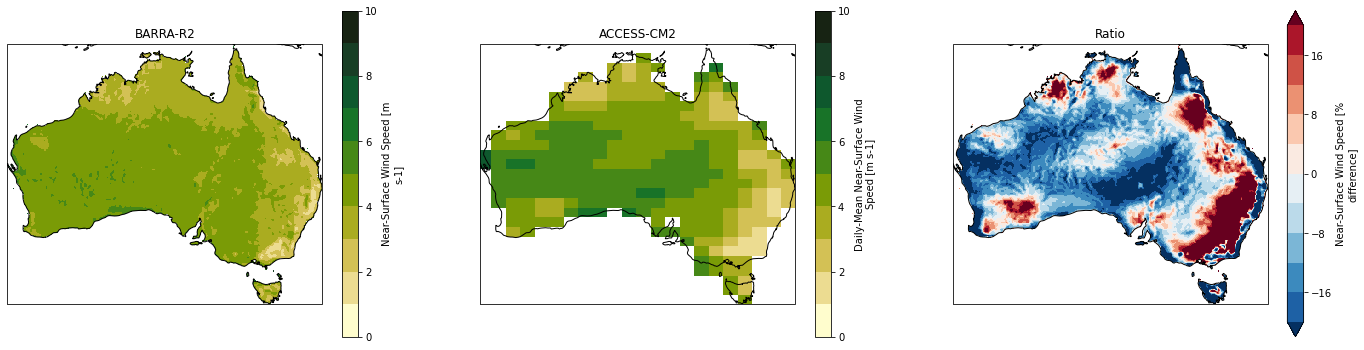

In [12]:
validation.spatial_comparison_plot(
    target_clim,
    hist_clim,
    comparison_ratio,
    'BARRA-R2',
    'ACCESS-CM2',
    clim_cbar["sfcWind"],
    diff_cbar["sfcWind"],
    clim_levels["sfcWind"],
    ratio_levels,
    'multiplicative',
    land_only=True,
    clim_extend='neither',
    print_mav=True,
)

### sfcWindmax

In [13]:
hist_clim, target_clim, comparison_diff, comparison_ratio = get_data("sfcWindmax", "ACCESS-CM2", "BARRA-R2")

In [ ]:
validation.spatial_comparison_plot(
    target_clim,
    hist_clim,
    comparison_diff,
    'BARRA-R2',
    'ACCESS-CM2',
    clim_cbar["sfcWindmax"],
    diff_cbar["sfcWindmax"],
    clim_levels["sfcWindmax"],
    diff_levels["sfcWindmax"],
    'additive',
    land_only=True,
    clim_extend='neither',
    print_mav=True,
)

mean absolute value: 12.37 


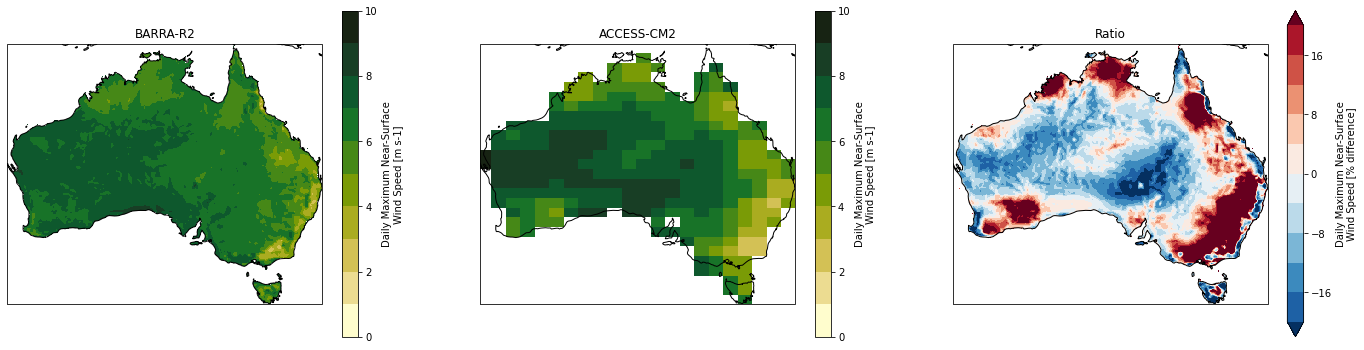

In [14]:
validation.spatial_comparison_plot(
    target_clim,
    hist_clim,
    comparison_ratio,
    'BARRA-R2',
    'ACCESS-CM2',
    clim_cbar["sfcWindmax"],
    diff_cbar["sfcWindmax"],
    clim_levels["sfcWindmax"],
    ratio_levels,
    'multiplicative',
    land_only=True,
    clim_extend='neither',
    print_mav=True,
)

### hursmin

In [7]:
hist_clim, target_clim, comparison_diff, comparison_ratio = get_data("hursmin", "ACCESS-CM2", "BARRA-R2")

In [ ]:
validation.spatial_comparison_plot(
    target_clim,
    hist_clim,
    comparison_diff,
    'BARRA-R2',
    'ACCESS-CM2',
    clim_cbar["hursmin"],
    diff_cbar["hursmin"],
    clim_levels["hursmin"],
    diff_levels["hursmin"],
    'additive',
    land_only=True,
    clim_extend='neither',
    print_mav=True,
)

mean absolute value: 13.87 


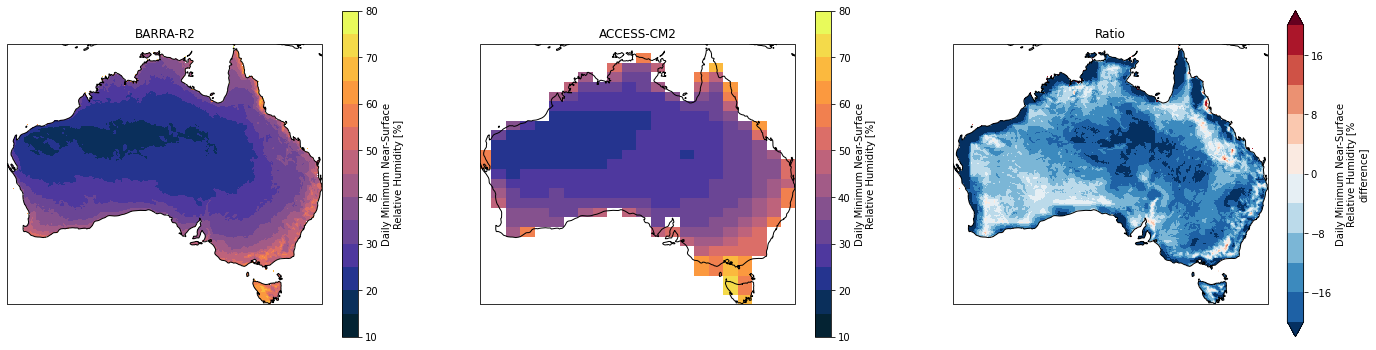

In [8]:
validation.spatial_comparison_plot(
    target_clim,
    hist_clim,
    comparison_ratio,
    'BARRA-R2',
    'ACCESS-CM2',
    clim_cbar["hursmin"],
    diff_cbar["hursmin"],
    clim_levels["hursmin"],
    ratio_levels,
    'multiplicative',
    land_only=True,
    clim_extend='neither',
    print_mav=True,
)

### hursmax

In [5]:
hist_clim, target_clim, comparison_diff, comparison_ratio = get_data("hursmax", "ACCESS-CM2", "BARRA-R2")

In [ ]:
validation.spatial_comparison_plot(
    target_clim,
    hist_clim,
    comparison_diff,
    'BARRA-R2',
    'ACCESS-CM2',
    clim_cbar["hursmax"],
    diff_cbar["hursmax"],
    clim_levels["hursmax"],
    diff_levels["hursmax"],
    'additive',
    land_only=True,
    clim_extend='neither',
    print_mav=True,
)

mean absolute value: 7.71 


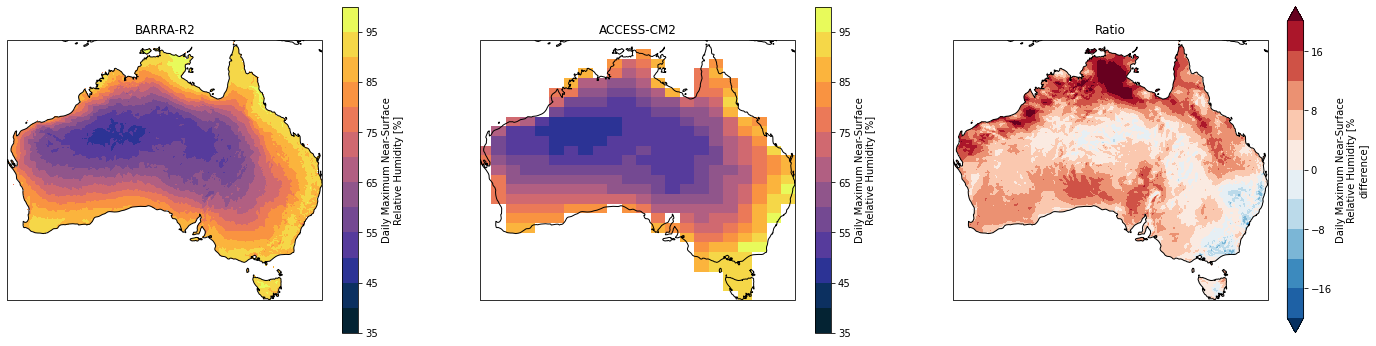

In [6]:
validation.spatial_comparison_plot(
    target_clim,
    hist_clim,
    comparison_ratio,
    'BARRA-R2',
    'ACCESS-CM2',
    clim_cbar["hursmax"],
    diff_cbar["hursmax"],
    clim_levels["hursmax"],
    ratio_levels,
    'multiplicative',
    land_only=True,
    clim_extend='neither',
    print_mav=True,
)